In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import importlib
import functions
import numpy as np
import json
import seaborn as sns
from typing import List, Dict

In [3]:
from functions import gov_exp

In [4]:
importlib.reload(functions)
from functions import gov_exp, gov_exp_by_age

# getting groups

In [ ]:
optical = gov_exp(
    inflation_adjustment=False,
    sector="optical",
    mask={"OPTIQUE MEDICALE": ["equality", "L_SC1", "and"]},
    indent=0,
)

In [ ]:
orthoprotheses = gov_exp(
    inflation_adjustment=False,
    sector="all",
    mask={"ORTHOPROTHESES(CHAP.7)": ["equality", "L_SC1", "and"]},
    indent=0,
)

In [ ]:
dmi_synthe = gov_exp(
    inflation_adjustment=False,
    sector="all",
    mask={"DMI D ORIGINE SYNTHETIQUE": ["equality", "L_SC1", "and"]},
    indent=0,
)

In [ ]:
audioprotheses = gov_exp(
    inflation_adjustment=False,
    sector="all",
    mask={
        "AUDIOPROTHESES ET ENTRETIEN, REPARATIONS ET ACCESSOIRES POUR PROCESSEUR": [
            "contains",
            "L_SC1",
            "or",
        ],
        "AUDIOPROTHESES ET ENTRETIEN, REPARATIONS ET ACCESSOIRES POUR PROCESSEURS": [
            "contains",
            "L_SC1",
            "or",
        ],
    },
    indent=0,
)

In [ ]:
ortheses = gov_exp(
    inflation_adjustment=False,
    sector="all",
    mask={"ORTHESES (PETIT APPAREILLAGE) (CHAP.1)": ["equality", "L_SC1", "and"]},
    indent=0,
)

In [ ]:
aerosol = gov_exp(
    inflation_adjustment=False,
    sector="all",
    mask={"APPAREIL GENERATEUR D AEROSOL": ["equality", "L_SC1", "and"]},
    indent=0,
)

In [ ]:
labels_name = ["optical", "orthoprotheses", "dmi_synthe", "audioprotheses", "ortheses", "aerosol"]
labels = [optical, orthoprotheses, dmi_synthe, audioprotheses, ortheses, aerosol]
dict = {labels_name[i]:labels[i] for i in range(6)}

In [ ]:
#do we separate all groups, like we differ group with their name or we differ it whether they are treated and controled ? try 2*

# getting data in a unique df

In [ ]:
i=0
for group_name in labels_name:
    
    if group_name == "optical":
        treatment = [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
    elif group_name == "audioprotheses":
        treatment = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
    else:
        treatment = [0 for j in range(10)]
    
    df = pd.DataFrame(
    {
        "year":dict[group_name][0].keys(),
        "expenditures":dict[group_name][0].values(),
        "treatment":treatment,
    }
    )

    df = pd.get_dummies(df, columns=['year'], prefix='', prefix_sep='').astype(int)

    if i == 0:
        df_final = df
        i+=1
    else:
        df_final = pd.concat([df_final, df], axis=0)

reference = "2014"

df_final.reset_index(inplace=True)
df_final.drop(columns=["index", reference], inplace=True)

for col in df_final.filter(like="2").columns:
    df_final[f'{col}_treatment'] = df_final["treatment"] * df_final[col]

In [ ]:
df_final.tail()

In [ ]:
df_final.to_csv("df_for_reg.csv")

In [ ]:
df_final = pd.read_csv("df_for_reg.csv", index_col=0)
df_final.columns

## log(y)

In [ ]:
import statsmodels.api as sm

X = df_final.drop(columns=["expenditures"])
X = sm.add_constant(X)
y = np.log(df_final["expenditures"])

In [ ]:
model = sm.OLS(y, X).fit()
print(model.summary())

## y

In [ ]:
import statsmodels.api as sm

X = df_final.drop(columns=["expenditures"])
X = sm.add_constant(X)
y = df_final["expenditures"]

model = sm.OLS(y, X).fit()
print(model.summary())

V2

In [ ]:
optical = gov_exp(
    inflation_adjustment=False,
    sector="optical",
    mask={"OPTIQUE MEDICALE": ["equality", "L_SC1", "and"]},
    indent=0,
)

In [ ]:
orthoprotheses = gov_exp(
    inflation_adjustment=False,
    sector="all",
    mask={"ORTHOPROTHESES(CHAP.7)": ["equality", "L_SC1", "and"]},
    indent=0,
)

In [ ]:
dmi_synthe = gov_exp(
    inflation_adjustment=False,
    sector="all",
    mask={"DMI D ORIGINE SYNTHETIQUE": ["equality", "L_SC1", "and"]},
    indent=0,
)

In [ ]:
audioprotheses = gov_exp(
    inflation_adjustment=False,
    sector="all",
    mask={
        "AUDIOPROTHESES ET ENTRETIEN, REPARATIONS ET ACCESSOIRES POUR PROCESSEUR": [
            "contains",
            "L_SC1",
            "or",
        ],
        "AUDIOPROTHESES ET ENTRETIEN, REPARATIONS ET ACCESSOIRES POUR PROCESSEURS": [
            "contains",
            "L_SC1",
            "or",
        ],
    },
    indent=0,
)

In [ ]:
ortheses = gov_exp(
    inflation_adjustment=False,
    sector="all",
    mask={"ORTHESES (PETIT APPAREILLAGE) (CHAP.1)": ["equality", "L_SC1", "and"]},
    indent=0,
)

In [ ]:
aerosol = gov_exp(
    inflation_adjustment=False,
    sector="all",
    mask={"APPAREIL GENERATEUR D AEROSOL": ["equality", "L_SC1", "and"]},
    indent=0,
)

In [ ]:
labels_name = ["optical", "orthoprotheses", "dmi_synthe", "audioprotheses", "ortheses", "aerosol"]
labels = [optical, orthoprotheses, dmi_synthe, audioprotheses, ortheses, aerosol]
dict = {labels_name[i]:labels[i] for i in range(6)}

In [ ]:
i=0
for group_name in labels_name:
    
    if group_name == "optical":
        treatment = [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
    elif group_name == "audioprotheses":
        treatment = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
    else:
        treatment = [0 for j in range(10)]
    
    df = pd.DataFrame(
    {
        "year":dict[group_name][0].keys(),
        "expenditures":dict[group_name][0].values(),
        "treatment":treatment,
    }
    )

    if i == 0:
        df_final = df
        i+=1
    else:
        df_final = pd.concat([df_final, df], axis=0)
    
df_final.head()

In [ ]:
df_final.dtypes

In [ ]:
df_final["after_treatment_year"] = 0

for i in range(len(df_final)):
    if df_final.iloc[i, 0] not in [str(j+2014) for j in range(5)]:
        df_final.iloc[i, 3] = 1

In [ ]:
df_final.drop(columns="year", inplace=True)

In [ ]:
df_final.head()

In [ ]:
df_final["treatment_year"] = df_final["treatment"] * df_final["after_treatment_year"]

In [ ]:
df_final.head()

# log(y)

In [ ]:
import statsmodels.api as sm

X = df_final.drop(columns=["expenditures"])
X = sm.add_constant(X)
y = np.log(df_final["expenditures"])

In [ ]:
model = sm.OLS(y, X).fit()
print(model.summary())

# y

In [ ]:
import statsmodels.api as sm

X = df_final.drop(columns=["expenditures"])
X = sm.add_constant(X)
y = df_final["expenditures"]

In [ ]:
model = sm.OLS(y, X).fit()
print(model.summary())

adding age

In [ ]:
importlib.reload(functions)
from functions import gov_exp_by_age

In [ ]:
optical = gov_exp_by_age(
    inflation_adjustment=False,
    sector="optical",
    mask={"OPTIQUE MEDICALE": ["equality", "L_SC1", "and"]},
    indent=0,
)

In [ ]:
orthoprotheses = gov_exp_by_age(
    inflation_adjustment=False,
    sector="all",
    mask={"ORTHOPROTHESES(CHAP.7)": ["equality", "L_SC1", "and"]},
    indent=0,
)

In [ ]:
dmi_synthe = gov_exp_by_age(
    inflation_adjustment=False,
    sector="all",
    mask={"DMI D ORIGINE SYNTHETIQUE": ["equality", "L_SC1", "and"]},
    indent=0,
)

In [ ]:
audioprotheses = gov_exp_by_age(
    inflation_adjustment=False,
    sector="all",
    mask={
        "AUDIOPROTHESES ET ENTRETIEN, REPARATIONS ET ACCESSOIRES POUR PROCESSEUR": [
            "contains",
            "L_SC1",
            "or",
        ],
        "AUDIOPROTHESES ET ENTRETIEN, REPARATIONS ET ACCESSOIRES POUR PROCESSEURS": [
            "contains",
            "L_SC1",
            "or",
        ],
    },
    indent=0,
)

In [ ]:
ortheses = gov_exp_by_age(
    inflation_adjustment=False,
    sector="all",
    mask={"ORTHESES (PETIT APPAREILLAGE) (CHAP.1)": ["equality", "L_SC1", "and"]},
    indent=0,
)

In [ ]:
aerosol = gov_exp_by_age(
    inflation_adjustment=False,
    sector="all",
    mask={"APPAREIL GENERATEUR D AEROSOL": ["equality", "L_SC1", "and"]},
    indent=0,
)

In [ ]:
labels_name = ["optical", "orthoprotheses", "dmi_synthe", "audioprotheses", "ortheses", "aerosol"]
labels = [optical, orthoprotheses, dmi_synthe, audioprotheses, ortheses, aerosol]
dict = {labels_name[i]:labels[i] for i in range(6)}

getting df with age range

In [ ]:
i=0
for group_name in labels_name:
    
    if group_name == "optical":
        treatment = [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
    elif group_name == "audioprotheses":
        treatment = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
    else:
        treatment = [0 for j in range(10)]
    
    data = []

    k=0
    for year, age_data in optical.items():
        for age_range, values in age_data.items():
            data.append({
                "year": year,
                "age_range": age_range,
                "treatment": treatment[k],
                "expenditures": values[1]
            })
        k+=1
    
    df = pd.DataFrame(data)

    df = pd.get_dummies(df, columns=['age_range'], prefix='', prefix_sep='').astype(int)

    if i == 0:
        df_final = df
        i+=1
    else:
        df_final = pd.concat([df_final, df], axis=0)
    
df_final.reset_index(inplace=True)
df_final.drop(columns="index", inplace=True)

df_final

In [ ]:
df_final["after_treatment_year"] = 0

mask = ~df_final.iloc[:, 0].isin([(j+2014) for j in range(5)])

# Appliquer le masque pour définir "after_treatment_year" à 1 là où le masque est True
df_final.loc[mask, "after_treatment_year"] = 1

In [ ]:
df.head()

----------------------------------

with age

In [ ]:
def getting_df_with_age(with_interaction = True):
    with open("../data/results/L_SC1_SC2_LPP_gov_exp_raw.json") as f:
        L_SC1 = json.load(f)
    
    list_group=list(L_SC1.keys())

    to_remove = ['CODES ARRIVES A ECHEANCE', 
    'ACCESSOIRES DE PRODUITS INSCRITS AU TITRE III', 
    "DISPOSITIFS MEDICAUX UTILISES DANS LE SYSTEME GASTRO-INTESTINAL", 
    "DISPOSITIFS MEDICAUX UTILISES DANS LE SYSTEME URO-GENITAL", 
    "DISPOSITIFS MEDICAUX UTILISES EN NEUROLOGIE", 
    "DISPOSITIFS MEDICAUX UTILISES EN ONCOLOGIE", 
    "DM, MATERIELS ET PRODUITS POUR LE TRAITEMENT DE PATHOLOGIES SPECIFIQUES", 
    'DISPOSITIFS MEDICAUX UTILISES DANS LE SYST CARDIO-VASCULAIRE',
    "DISPOISTIFS MEDICAUX UTILISES DANS LE SYSTEME CARDIO_VASCULAIRE",
    'DM DE MAINTIEN A DOMICILE ET D AIDE A LA VIE POUR MALADES ET HANDICAPES',
    "DM DE MAINTIEN A DOMICILE ET D AIDE A LA VIE POUR MALADES ET HANDICAPE",
    'DMI ISSUS DE DERIVES ORIGINE ANIMALE NON VIABLES OU EN COMPORTANT', 
    'IMPLANTS ISSUS DE DERIVES HUMAINS_GREFFONS',
    "IMPLANTS ISSUS DE DERIVES HUMAINS-GREFFONS",
    'PODO_ORTHESES',
    "PODO-ORTHESES",
    ]
    #problem was that some elements was missing with these title, or the expends were constant.

    for element in to_remove:
        if element in list_group:
            list_group.remove(element)

    #count = 0
    variable_dict = {}
    dfs = [] # Liste pour stocker les DataFrames, plus rapide que de concat à chaque itération
    years = [i+2014 for i in range(10)]

    for title in list_group:
        print(title)
        variable_name = title
        #print(variable_name, type(variable_name))
        if title in ["AUDIOPROTHESES ET ENTRETIEN, REPARATIONS ET ACCESSOIRES POUR PROCESSEURS"]:
            continue

        elif title == "AUDIOPROTHESES ET ENTRETIEN, REPARATIONS ET ACCESSOIRES POUR PROCESSEUR":
            variable_dict[variable_name] = gov_exp_by_age(
                inflation_adjustment=False,
                sector="all",
                mask={title: ["equality", "L_SC1", "or"], "AUDIOPROTHESES ET ENTRETIEN, REPARATIONS ET ACCESSOIRES POUR PROCESSEURS":["equality", "L_SC1", "or"]},
                indent=0,
            )

        #elif title == "DISPOISTIFS MEDICAUX UTILISES DANS LE SYSTEME CARDIO_VASCULAIRE":
        #    variable_dict[variable_name] = gov_exp_by_age(
        #        inflation_adjustment=False,
        #        sector="all",
        #        mask={title: ["equality", "L_SC1", "or"], "DISPOSITIFS MEDICAUX UTILISES DANS LE SYSTEME CARDIO-VASCULAIRE":["equality", "L_SC1", "or"]},
        #        indent=0,
        #    )

        #elif title == "DM DE MAINTIEN A DOMICILE ET D AIDE A LA VIE POUR MALADES ET HANDICAPE":
        #    variable_dict[variable_name] = gov_exp_by_age(
        #        inflation_adjustment=False,
        #        sector="all",
        #        mask={title: ["equality", "L_SC1", "or"], "DM DE MAINTIEN A DOMICILE ET D AIDE A LA VIE POUR MALADES ET HANDICAPES":["equality", "L_SC1", "or"]},
        #        indent=0,
        #    )

        #elif title == "IMPLANTS ISSUS DE DERIVES HUMAINS-GREFFONS":
        #    variable_dict[variable_name] = gov_exp_by_age(
        #        inflation_adjustment=False,
        #        sector="all",
        #        mask={title: ["equality", "L_SC1", "or"], "IMPLANTS ISSUS DE DERIVES HUMAINS_GREFFONS":["equality", "L_SC1", "or"]},
        #        indent=0,
        #    )

        #elif title == "PODO-ORTHESES":
        #    variable_dict[variable_name] = gov_exp_by_age(
        #        inflation_adjustment=False,
        #        sector="all",
        #        mask={title: ["equality", "L_SC1", "or"], "PODO_ORTHESES":["equality", "L_SC1", "or"]},
        #        indent=0,
        #    )

        else:
            variable_dict[variable_name] = gov_exp_by_age(
                inflation_adjustment=False,
                sector="all",
                mask={title: ["equality", "L_SC1", "and"]},
                indent=0,
            )

        print(f"got all '{title} expenditures'")

        #if group_name == "optical":
        #    treatment = [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
        #elif group_name == "AUDIOPROTHESES ET ENTRETIEN, REPARATIONS ET ACCESSOIRES POUR PROCESSEUR":
        #    treatment = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
        #else:
        #    treatment = [0 for j in range(10)]

        data = []

        for year, age_data in variable_dict[variable_name].items():
            for age_range, values in age_data.items():
                data.append({
                    "year": year,
                    "age_range": age_range,
                    #"treatment": treatment[k],
                    "expenditures": values[1],
                    "group":title,
                })

        df = pd.DataFrame(data)

        print(df)

        print(f"got {title} df")
        dfs.append(df)

    df_final = pd.concat(dfs, axis=0)
        #if i == 0:
        #    df_final = df
        #    i+=1
        #else:
        #    df_final = pd.concat([df_final, df], axis=0)

    df_final = pd.get_dummies(df_final, columns=['group'], prefix='', prefix_sep='')
    df_final = pd.get_dummies(df_final, columns=['year'], prefix='', prefix_sep='')
    df_final = pd.get_dummies(df_final, columns=['age_range'], prefix='', prefix_sep='')
    
    if with_interaction == True:
        for col in df_final.filter(like="20").columns:
            df_final[f"interact. audio x year{col}"] = df_final["AUDIOPROTHESES ET ENTRETIEN, REPARATIONS ET ACCESSOIRES POUR PROCESSEUR"] * df_final[col]
            df_final[f"interact. optique x year{col}"] = df_final["OPTIQUE MEDICALE"] * df_final[col]
            df_final[f"interact. (audio+optical) x year{col}"] = (df_final["AUDIOPROTHESES ET ENTRETIEN, REPARATIONS ET ACCESSOIRES POUR PROCESSEUR"]+df_final["OPTIQUE MEDICALE"]) * df_final[col]
        return df_final

    else:
        return df_final

In [ ]:
df_aged = getting_df_with_age(with_interaction=True)

In [ ]:
df_aged.reset_index(inplace=True)

In [ ]:
df_aged = df_aged.drop(columns=["index"])

# work on the data

## WITHOUT AGE

In [4]:
df = pd.read_excel("df_without_age_range_for_reg_30-10.xlsx", index_col=0)

In [5]:
df["expenditures"] = np.log(df["expenditures"])
df.head()

,expenditures,"ADJONCTIONS, OPTIONS ET REPARATIONS APPLICABLES AUX FAUTEUILS ROULANTS",APPAREIL GENERATEUR D AEROSOL,"ARTICLES POUR PANSEMENTS, MATERIELS DE CONTENTION","AUDIOPROTHESES ET ENTRETIEN, REPARATIONS ET ACCESSOIRES POUR PROCESSEUR",DISPOSITIFS MEDICAUX IMPLANTABLES ACTIFS,DMI D ORIGINE SYNTHETIQUE,FAUTEUILS ROULANTS,OPTIQUE MEDICALE,ORTHESES,...,interact. (audio+optical) x year2020,interact. audio x year2021,interact. optique x year2021,interact. (audio+optical) x year2021,interact. audio x year2022,interact. optique x year2022,interact. (audio+optical) x year2022,interact. audio x year2023,interact. optique x year2023,interact. (audio+optical) x year2023
0,20.235073,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20.300226,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20.356152,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,20.377579,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,20.426194,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## all

In [6]:
import statsmodels.api as sm

X = df.drop(columns=(["expenditures"] + [col for col in df.columns if "2014" in col] + [col for col in df.columns if "audio x" in col or "optique x" in col]))
X = sm.add_constant(X)
y = df["expenditures"]

In [7]:
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           expenditures   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     89.86
Date:                Thu, 31 Oct 2024   Prob (F-statistic):           1.19e-63
Time:                        08:58:44   Log-Likelihood:                -9.1866
No. Observations:                 140   AIC:                             82.37
Df Residuals:                     108   BIC:                             176.5
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                                                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

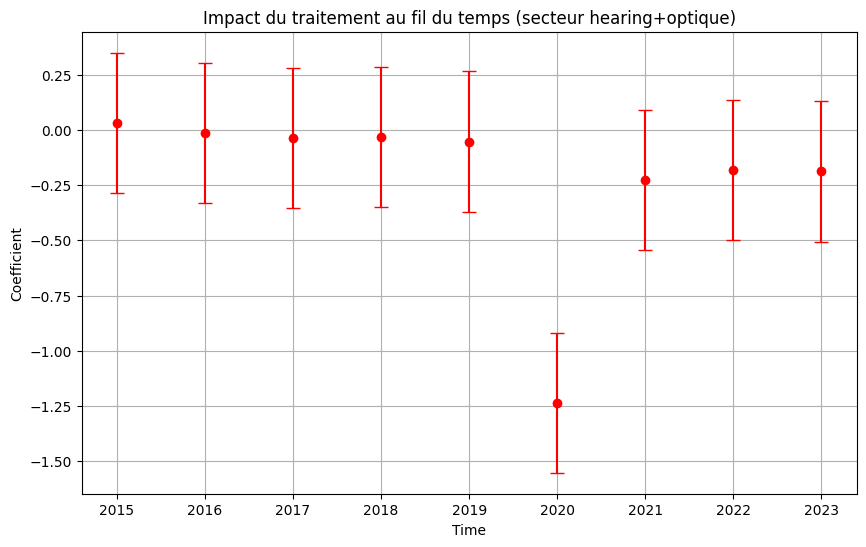

In [8]:
time_periods = [i+2015 for i in range(9)]
coefficients = model.params[-9:]
std_errors = model.bse[-9:]


plt.figure(figsize=(10, 6))

plt.errorbar(time_periods, coefficients, yerr=std_errors, fmt='o', color='red', ecolor='red', capsize=5)

plt.xlabel("Time")
plt.ylabel("Coefficient")
plt.title("Impact du traitement au fil du temps (secteur hearing+optique)")
plt.grid(True)

plt.show()

## optical

In [9]:
import statsmodels.api as sm

X = df.drop(columns=(["expenditures"] + [col for col in df.columns if "audio" in col.lower()] + [col for col in df.columns if "2014" in col]))
X = sm.add_constant(X)
y = df["expenditures"]

In [10]:
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           expenditures   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     194.7
Date:                Thu, 31 Oct 2024   Prob (F-statistic):           3.50e-81
Time:                        08:59:19   Log-Likelihood:                 43.521
No. Observations:                 140   AIC:                            -23.04
Df Residuals:                     108   BIC:                             71.09
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                                                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

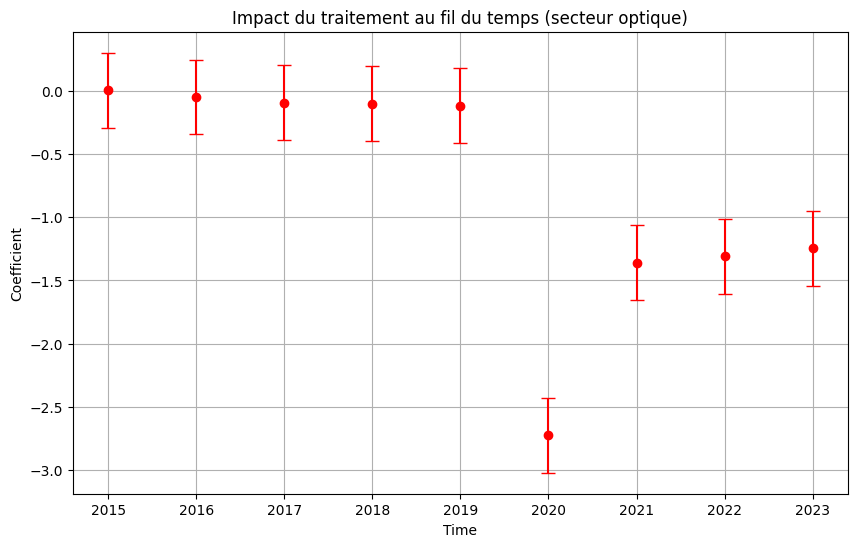

In [11]:
time_periods = [i+2015 for i in range(9)]
coefficients = model.params[-9:]
std_errors = model.bse[-9:]


plt.figure(figsize=(10, 6))

plt.errorbar(time_periods, coefficients, yerr=std_errors, fmt='o', color='red', ecolor='red', capsize=5)

plt.xlabel("Time")
plt.ylabel("Coefficient")
plt.title("Impact du traitement au fil du temps (secteur optique)")
plt.grid(True)

plt.show()

## hearing

In [21]:
import statsmodels.api as sm

X = df.drop(columns=(["expenditures"] + [col for col in df.columns if "optical" in col.lower()] + [col for col in df.columns if "optique" in col.lower()] + [col for col in df.columns if "2014" in col]))
X = sm.add_constant(X)
y = df["expenditures"]

In [22]:
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           expenditures   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     83.87
Date:                Thu, 31 Oct 2024   Prob (F-statistic):           4.11e-62
Time:                        09:01:21   Log-Likelihood:                -13.825
No. Observations:                 140   AIC:                             91.65
Df Residuals:                     108   BIC:                             185.8
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                                                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

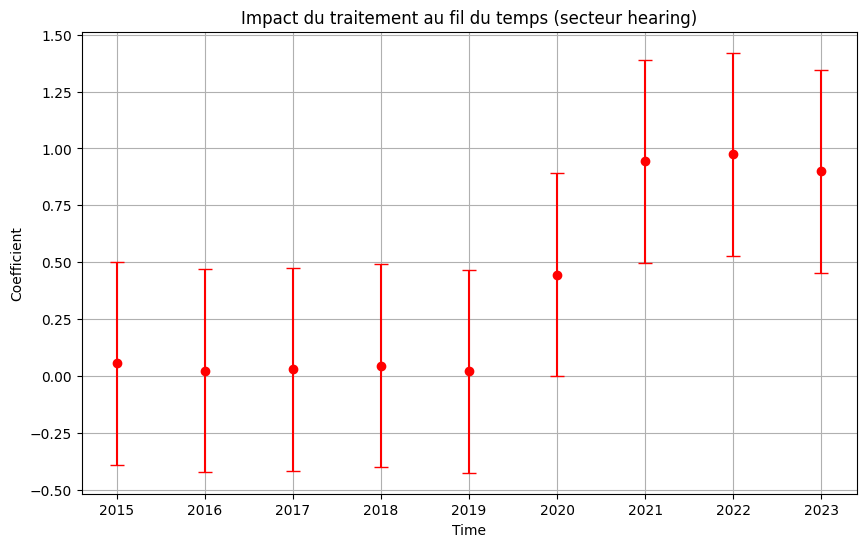

In [23]:
time_periods = [i+2015 for i in range(9)]
coefficients = model.params[-9:]
std_errors = model.bse[-9:]


plt.figure(figsize=(10, 6))

plt.errorbar(time_periods, coefficients, yerr=std_errors, fmt='o', color='red', ecolor='red', capsize=5)

plt.xlabel("Time")
plt.ylabel("Coefficient")
plt.title("Impact du traitement au fil du temps (secteur hearing)")
plt.grid(True)

plt.show()

## WITH AGE RANGE

In [85]:
df_aged = pd.read_excel("df_aged_for_reg_30-10.xlsx", index_col=0)

In [86]:
df_aged = df_aged[df_aged["expenditures"]!=0]

In [87]:
df_aged.columns

Index(['expenditures',
       'ADJONCTIONS, OPTIONS ET REPARATIONS APPLICABLES AUX FAUTEUILS ROULANTS',
       'APPAREIL GENERATEUR D AEROSOL',
       'ARTICLES POUR PANSEMENTS, MATERIELS DE CONTENTION',
       'AUDIOPROTHESES ET ENTRETIEN, REPARATIONS ET ACCESSOIRES POUR PROCESSEUR',
       'DISPOSITIFS MEDICAUX IMPLANTABLES ACTIFS', 'DMI D ORIGINE SYNTHETIQUE',
       'FAUTEUILS ROULANTS', 'OPTIQUE MEDICALE', 'ORTHESES',
       'ORTHESES (PETIT APPAREILLAGE) (CHAP.1)', 'ORTHOPROTHESES(CHAP.7)',
       'PROTHESES EXTERNES NON ORTHOPEDIQUES',
       'PROTHESES OCULAIRES ET FACIALES', 'VEHICULES DIVERS', '2014', '2015',
       '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '0-20',
       '20-40', '40-60', '60-80', 'interact. audio x year2014',
       'interact. optique x year2014', 'interact. (audio+optical) x year2014',
       'interact. audio x year2015', 'interact. optique x year2015',
       'interact. (audio+optical) x year2015', 'interact. audio x year2016',
     

In [88]:
df_aged = df_aged.drop(columns=["0-20"])

In [89]:
interact_columns = df_aged.filter(like="interact.").columns
dash_columns = [col for col in df_aged.columns if "-" in col]

for interact_col in interact_columns:
    for dash_col in dash_columns:
        df_aged[f"{interact_col}_{dash_col}"] = df_aged[interact_col] * df_aged[dash_col]

In [90]:
df_aged["expenditures"] = np.log(df_aged["expenditures"])
df_aged.head()

,expenditures,"ADJONCTIONS, OPTIONS ET REPARATIONS APPLICABLES AUX FAUTEUILS ROULANTS",APPAREIL GENERATEUR D AEROSOL,"ARTICLES POUR PANSEMENTS, MATERIELS DE CONTENTION","AUDIOPROTHESES ET ENTRETIEN, REPARATIONS ET ACCESSOIRES POUR PROCESSEUR",DISPOSITIFS MEDICAUX IMPLANTABLES ACTIFS,DMI D ORIGINE SYNTHETIQUE,FAUTEUILS ROULANTS,OPTIQUE MEDICALE,ORTHESES,...,interact. (audio+optical) x year2022_60-80,interact. audio x year2023_20-40,interact. audio x year2023_40-60,interact. audio x year2023_60-80,interact. optique x year2023_20-40,interact. optique x year2023_40-60,interact. optique x year2023_60-80,interact. (audio+optical) x year2023_20-40,interact. (audio+optical) x year2023_40-60,interact. (audio+optical) x year2023_60-80
0,17.288739,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,17.951012,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,18.676746,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,19.779053,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17.347670,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# all

In [91]:
import statsmodels.api as sm

X = df_aged.drop(columns=(["expenditures"] + [col for col in df_aged.columns if "2014" in col] + [col for col in df_aged.columns if "year" in col and "-" not in col] + [col for col in df_aged.columns if "audio x" in col or "optique x" in col]))
X = sm.add_constant(X)
y = df_aged["expenditures"]

In [92]:
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           expenditures   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     38.12
Date:                Thu, 31 Oct 2024   Prob (F-statistic):          1.88e-142
Time:                        10:09:45   Log-Likelihood:                -728.32
No. Observations:                 557   AIC:                             1563.
Df Residuals:                     504   BIC:                             1792.
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                                                                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [93]:
_20_40 = [col for col in X.columns if "20-40" in col]
_20_40.remove("20-40")

_40_60 = [col for col in X.columns if "40-60" in col]
_40_60.remove("40-60")

_60_80 = [col for col in X.columns if "60-80" in col]
_60_80.remove("60-80")

In [94]:
params = pd.DataFrame(model.params)
std = pd.DataFrame(model.bse)

In [95]:
interact_20_40 = params[params.index.str.contains("_20-40")]
interact_40_60 = params[params.index.str.contains("_40-60")]
interact_60_80 = params[params.index.str.contains("_60-80")]

interact_20_40_std = std[std.index.str.contains("_20-40")]
interact_40_60_std = std[std.index.str.contains("_40-60")]
interact_60_80_std = std[std.index.str.contains("_60-80")]

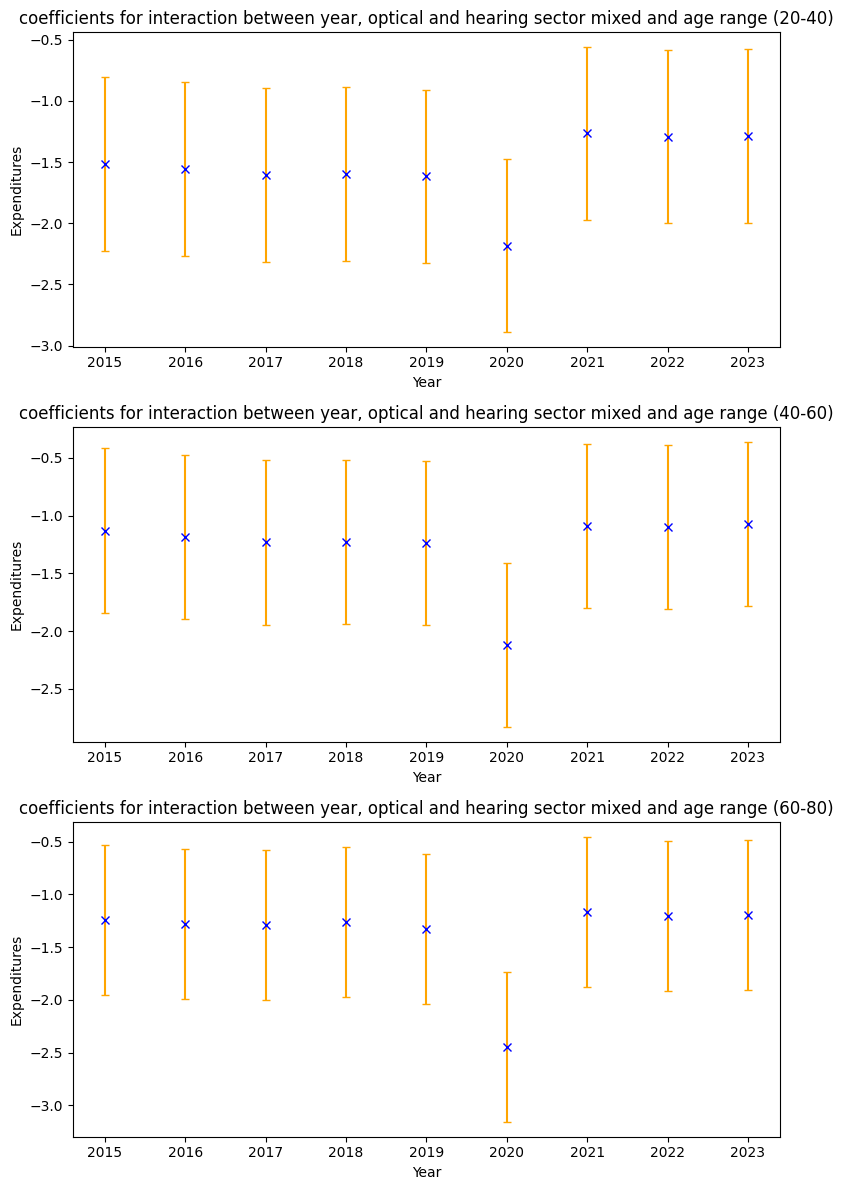

In [96]:
width = 0.35
time_periods = [i+2015 for i in range(9)]
fig, axes = plt.subplots(3, 1, figsize=(8, 12))
axes = axes.flatten()

axes[0].errorbar(time_periods, interact_20_40.iloc[:,0], yerr=interact_20_40_std.iloc[:,0], fmt='x', color='blue', ecolor='orange', capsize=3)
axes[0].set_title(
    "coefficients for interaction between year, optical and hearing sector mixed and age range (20-40)"
)

axes[1].errorbar(time_periods, interact_40_60.iloc[:,0], yerr=interact_40_60_std.iloc[:,0], fmt='x', color='blue', ecolor='orange', capsize=3)
axes[1].set_title("coefficients for interaction between year, optical and hearing sector mixed and age range (40-60)")

axes[2].errorbar(time_periods, interact_60_80.iloc[:,0], yerr=interact_60_80_std.iloc[:,0], fmt='x', color='blue', ecolor='orange', capsize=3)
axes[2].set_title("coefficients for interaction between year, optical and hearing sector mixed and age range (60-80)")

for i in range(len(axes)):

    axes[i].set_xlabel("Year")
    axes[i].set_ylabel("Expenditures")
    axes[i].set_xticks(time_periods)

plt.tight_layout()
plt.show()

## optical

In [97]:
import statsmodels.api as sm

X = df_aged.drop(columns=(["expenditures"] + [col for col in df_aged.columns if "2014" in col] + [col for col in df_aged.columns if "year" in col and "-" not in col] + [col for col in df_aged.columns if "audio" in col]))
X = sm.add_constant(X)
y = df_aged["expenditures"]

In [98]:
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           expenditures   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     39.69
Date:                Thu, 31 Oct 2024   Prob (F-statistic):          6.70e-146
Time:                        10:09:45   Log-Likelihood:                -719.32
No. Observations:                 557   AIC:                             1545.
Df Residuals:                     504   BIC:                             1774.
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                                                                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [99]:
_20_40 = [col for col in X.columns if "20-40" in col]
_20_40.remove("20-40")

_40_60 = [col for col in X.columns if "40-60" in col]
_40_60.remove("40-60")

_60_80 = [col for col in X.columns if "60-80" in col]
_60_80.remove("60-80")

In [100]:
params = pd.DataFrame(model.params)
std = pd.DataFrame(model.bse)

In [101]:
interact_20_40 = params[params.index.str.contains("_20-40")]
interact_40_60 = params[params.index.str.contains("_40-60")]
interact_60_80 = params[params.index.str.contains("_60-80")]

interact_20_40_std = std[std.index.str.contains("_20-40")]
interact_40_60_std = std[std.index.str.contains("_40-60")]
interact_60_80_std = std[std.index.str.contains("_60-80")]

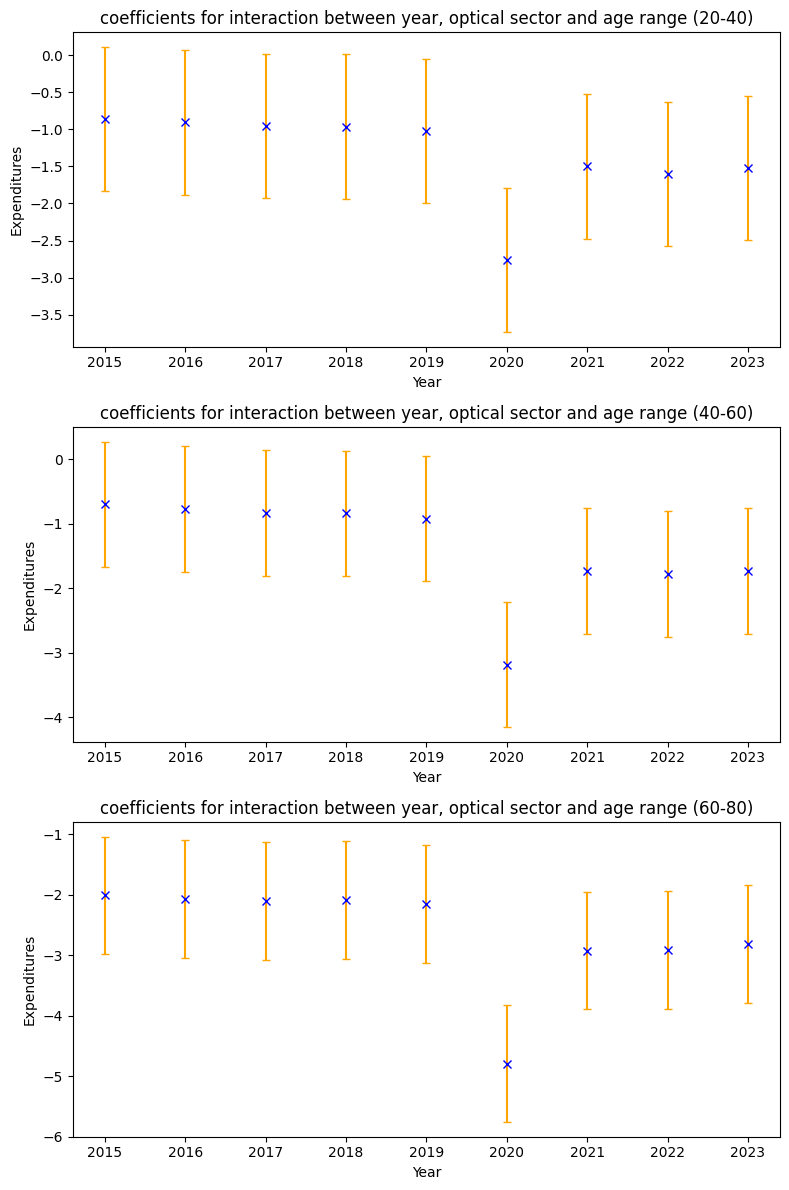

In [102]:
width = 0.35
time_periods = [i+2015 for i in range(9)]
fig, axes = plt.subplots(3, 1, figsize=(8, 12))
axes = axes.flatten()

axes[0].errorbar(time_periods, interact_20_40.iloc[:,0], yerr=interact_20_40_std.iloc[:,0], fmt='x', color='blue', ecolor='orange', capsize=3)
axes[0].set_title(
    "coefficients for interaction between year, optical sector and age range (20-40)"
)

axes[1].errorbar(time_periods, interact_40_60.iloc[:,0], yerr=interact_40_60_std.iloc[:,0], fmt='x', color='blue', ecolor='orange', capsize=3)
axes[1].set_title("coefficients for interaction between year, optical sector and age range (40-60)")

axes[2].errorbar(time_periods, interact_60_80.iloc[:,0], yerr=interact_60_80_std.iloc[:,0], fmt='x', color='blue', ecolor='orange', capsize=3)
axes[2].set_title("coefficients for interaction between year, optical sector and age range (60-80)")

for i in range(len(axes)):

    axes[i].set_xlabel("Year")
    axes[i].set_ylabel("Expenditures")
    axes[i].set_xticks(time_periods)

plt.tight_layout()
plt.show()

## hearing

In [103]:
import statsmodels.api as sm

X = df_aged.drop(columns=(["expenditures"] + [col for col in df_aged.columns if "2014" in col] + [col for col in df_aged.columns if "year" in col and "-" not in col] + [col for col in df_aged.columns if "optical" in col or "optique" in col]))
X = sm.add_constant(X)
y = df_aged["expenditures"]

In [104]:
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           expenditures   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     36.85
Date:                Thu, 31 Oct 2024   Prob (F-statistic):          1.38e-139
Time:                        10:09:46   Log-Likelihood:                -735.80
No. Observations:                 557   AIC:                             1578.
Df Residuals:                     504   BIC:                             1807.
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                                                                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [105]:
_20_40 = [col for col in X.columns if "20-40" in col]
_20_40.remove("20-40")

_40_60 = [col for col in X.columns if "40-60" in col]
_40_60.remove("40-60")

_60_80 = [col for col in X.columns if "60-80" in col]
_60_80.remove("60-80")

In [106]:
params = pd.DataFrame(model.params)
std = pd.DataFrame(model.bse)

In [107]:
interact_20_40 = params[params.index.str.contains("_20-40")]
interact_40_60 = params[params.index.str.contains("_40-60")]
interact_60_80 = params[params.index.str.contains("_60-80")]

interact_20_40_std = std[std.index.str.contains("_20-40")]
interact_40_60_std = std[std.index.str.contains("_40-60")]
interact_60_80_std = std[std.index.str.contains("_60-80")]

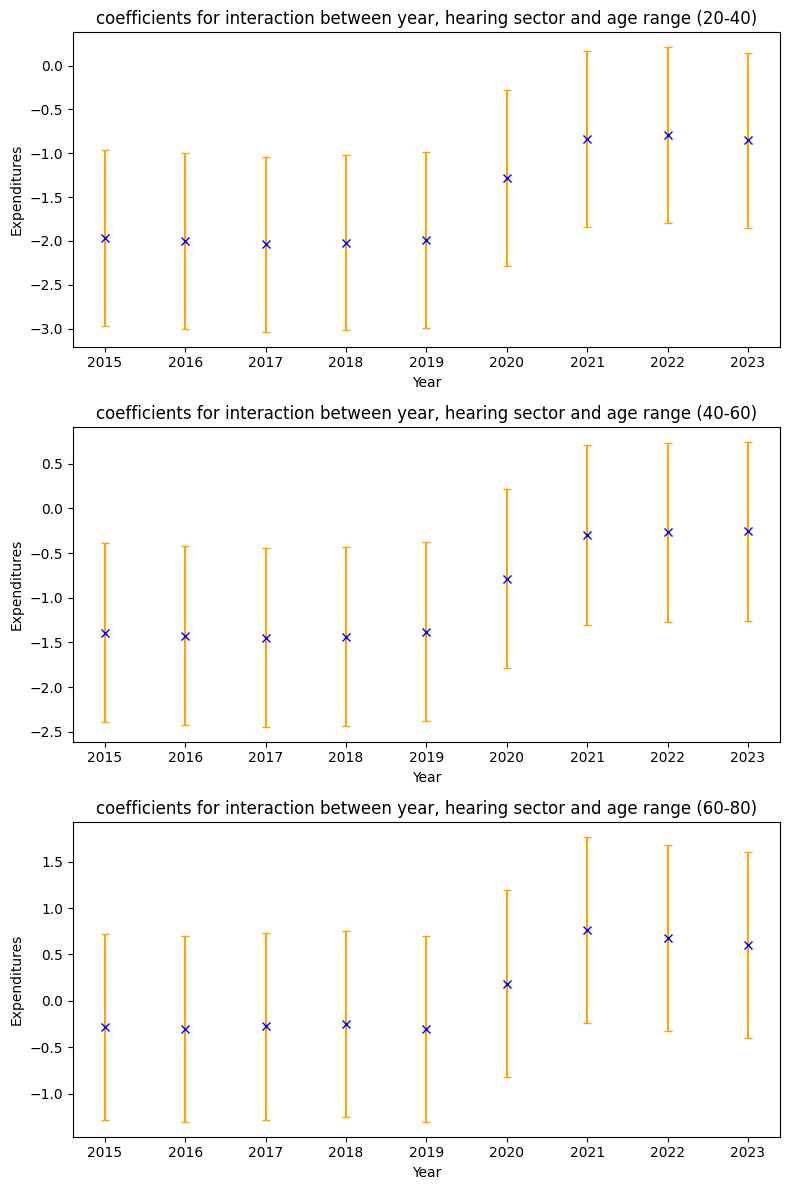

In [108]:
width = 0.35
time_periods = [i+2015 for i in range(9)]
fig, axes = plt.subplots(3, 1, figsize=(8, 12))
axes = axes.flatten()

axes[0].errorbar(time_periods, interact_20_40.iloc[:,0], yerr=interact_20_40_std.iloc[:,0], fmt='x', color='blue', ecolor='orange', capsize=3)
axes[0].set_title(
    "coefficients for interaction between year, hearing sector and age range (20-40)"
)

axes[1].errorbar(time_periods, interact_40_60.iloc[:,0], yerr=interact_40_60_std.iloc[:,0], fmt='x', color='blue', ecolor='orange', capsize=3)
axes[1].set_title("coefficients for interaction between year, hearing sector and age range (40-60)")

axes[2].errorbar(time_periods, interact_60_80.iloc[:,0], yerr=interact_60_80_std.iloc[:,0], fmt='x', color='blue', ecolor='orange', capsize=3)
axes[2].set_title("coefficients for interaction between year, hearing sector and age range (60-80)")

for i in range(len(axes)):

    axes[i].set_xlabel("Year")
    axes[i].set_ylabel("Expenditures")
    axes[i].set_xticks(time_periods)

plt.tight_layout()
plt.show()